In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import pandas as pd
import secrets
from networkx.algorithms import community

%matplotlib inline

In [6]:
def parenthem(G):
    allregions = []
    for node in G.nodes():
        if 'dn_name' in G.nodes[node]:
            s = G.nodes[node]['dn_name']
            substrings = s.split("_")
            allregions.append(substrings[0])
    allregions = list(set(allregions))
    return allregions

#plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1

    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

# Generate n random colors in hexadecimal format
def generatecolors(n):
    colors = ['#' + hex(secrets.randbits(24))[2:].zfill(6) for _ in range(n)]
    return colors


def compute_stats(G,parent_colors):
    n = len(nx.nodes(G)) # num nodes 
    m = len(nx.edges(G)) # num edges
    kmean = (2*m)/n # mean degree formula for undirected graph
    C = nx.transitivity(G) # clustering coeffcient

    print(f'number of nodes, n  = {n}')
    print(f'number of edges, m  = {m}')
    print(f'mean degree,    <k> = %5.2f' % kmean)
    print(f'clustering coefficient, C     = %5.2f' % C)
    #print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
    deg = [x[1] for x in nx.degree(G)] # putting the degree component of nx.degree into an array
    plt.rcParams["figure.figsize"] = (15,10)
    node_ops = {"node_size":50}
    edge_ops = {"width": .50, "alpha": 1, "edge_color": "black"}
    pos=nx.spring_layout(G)
    
    parent_dict = {}
    parents = parenthem(G)
    for i, parent in enumerate(parents):
        parent_dict[parent] = parent_colors[i]

    colors = [parent_dict[G.nodes[node]['dn_name'].split("_")[0]] for node in G.nodes()]
    plot_CCDF(deg)
    limits=plt.axis('off')
    nx.draw_networkx_nodes(G, pos, **node_ops, node_color=colors)
    nx.draw_networkx_edges(G, pos, **edge_ops)
    #nx.draw_networkx_labels(G,pos)
    
    handles = [mpatches.Patch(color=color, label=parent) for parent, color in parent_dict.items()]
    plt.legend(handles=handles, title='Parent Region', loc='upper left', bbox_to_anchor=(1, 1),ncol = 2)
    plt.show()

number of nodes, n  = 1015
number of edges, m  = 37477
mean degree,    <k> = 73.85
clustering coefficient, C     =  0.51


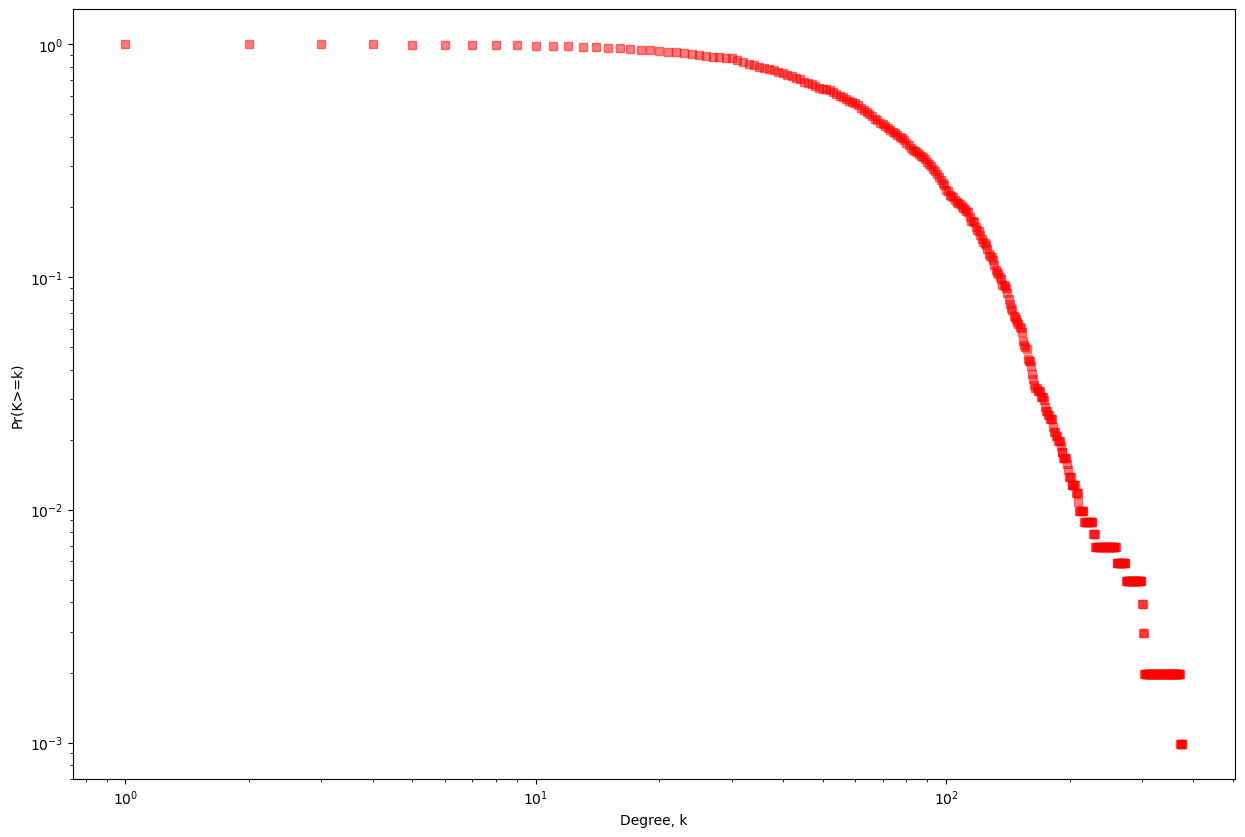

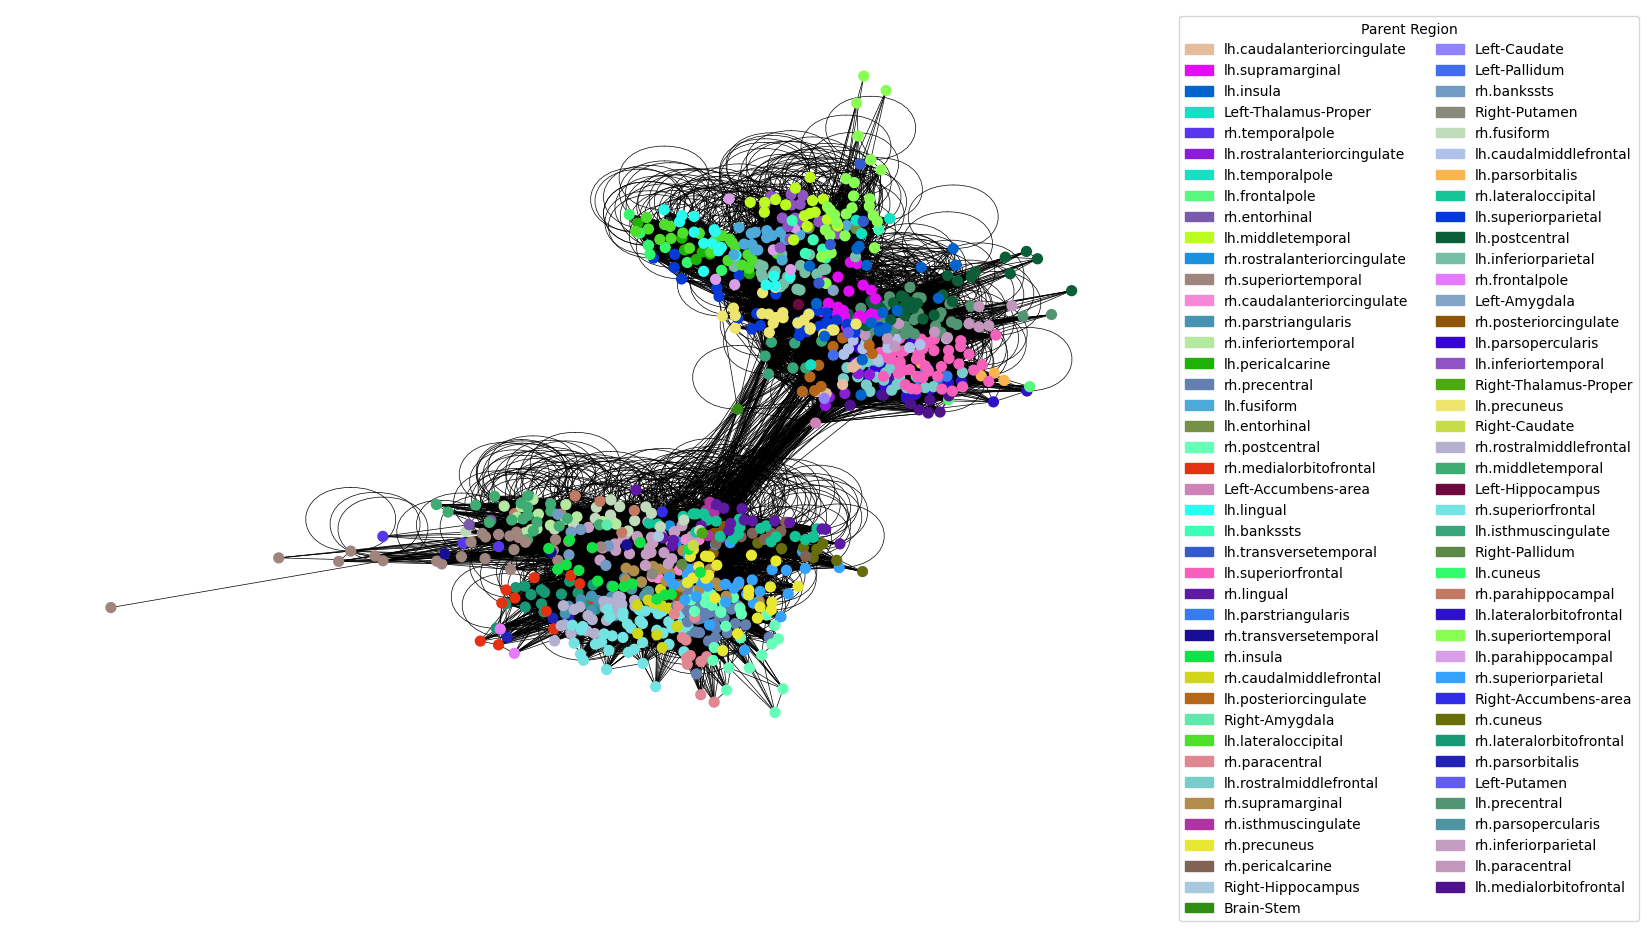

In [7]:
fname1 = 'budapest_connectome_low_confidence.graphml'
fname2 = 'budapest_connectome_medium_confidence.graphml'
fname3 = 'budapest_connectome_high_confidence.graphml'

G1 = nx.read_graphml('./' + fname1)
G2 = nx.read_graphml('./' + fname2)
G3 = nx.read_graphml('./' + fname3)

parent_colors = generatecolors(83)

compute_stats(G1,parent_colors)

In [11]:
##CORRECT FUNCTIONS
def drawGz(G,z):
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    values = []
    values = list(z.values())
    node_colors = []

    if len(list(set(values))) == 2:
        colors = ['blue','red']
    else:
        colors = parent_colors
        

    node_colors = []
    for i in values:
        node_colors.append(colors[int(i)])

    nx.draw_networkx(G,with_labels=False,node_size=100,width=0.5,node_color=node_colors,alpha=1,edge_color = 'black') # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r

    ##### do not modify above here #####

    
    ### YOUR CODE
    edges = list(G.edges())
    for e in edges:
        r = z[int(e[0])]
        s = z[int(e[1])]
        wrs[r,s] = wrs[r,s] + 1
        wrs[s,r] = wrs[s,r] + 1

    kpr = np.sum(wrs,axis=1)
    ##### do not modify below here #####

    return wrs,kpr

def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####

    
    ### YOUR CODE
    for i in range(1,n+1):
        z[i] = int(rnd.randint(0,c-1))

    ##### do not modify below here #####

    return z

def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION

def plotLL(LL,pc,n):
    # DO NOT MODIFY THIS FUNCTION
    # This function makes a nice plot of the log-likelihood trajectory
    #
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)

    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()

def makeAMove(G,z,c,f):
    # For each non 'frozen' node in the current partition, this function tries all (c-1) possible group moves for it
    # It returns the combination of [node i and new group r] that produces the best log-likelihood over the non-frozen set
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf            # the best log-likelihood over all considered moves
    for i in G.nodes():        # loop over all nodes i
        if f[int(i)] == 0:          # if i is not frozen
            s = int(z[int(i)])      #  get current label of i
            for r in range(c): #  then loop over all groups r
                #print(f'v[{i}] s = {s}, r={r}, {r!=s}') # for debugging
                
                ##### do not modify above here #####

                
                ## YOUR CODE
                if r != s:
                    z[int(i)] = r
                    wrs,kpr = tabulate_wk(G,z,c)
                    thisL = dcsbm_LogL(wrs,kpr)
                    if thisL > bestL:
                        bestL = thisL
                        bestMove = [int(i),r]
                ##### do not modify below here #####    
            z[int(i)] = s    #changed
    return bestL,bestMove

def run_OnePhase(G,z0,c):
    # Runs one phase, initialized from partition z0
    # Returns the best partition found in the phase and the list of LogL values for all the phase's partitions
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy      # for copy.deepcopy() function
    n    = G.order() # n, number of nodes
    LL   = []        # stores log-likelihoods over the entire algorithm (via .append)
    halt = 0         # flag: =0 if Lstar > L0 at the end of the phase; =1 if Lstar <= L0

    # initialize the phase
    wrs,kpr = tabulate_wk(G,z0,c)      # wrs, kpr, initial DC-SBM parameters
    L0      = dcsbm_LogL(wrs,kpr)      # store initial DC-SBM log-likelihood
    LL.append(L0)                      # track log-likelihood

    f     = dict.fromkeys(range(1,n+1), 0) # initially, all nodes unfrozen (tricky python)
    t     = 0                          # number of frozen nodes in this phase
    Lstar = L0                         # initially, z0 has the best LogL
    zstar = copy.deepcopy(z0)          # and z0 is the best partition
    tstar = t                          # tstar = 0

    # loop over all the nodes in G, making greedy move for each
    zt = copy.deepcopy(z0)             # start the loop at z0
    for j in range(n):
        #print(f'step {j}') # for debugging

        ##### do not modify above here #####

        
        ### YOUR CODE
        choiceL, choiceMove = makeAMove(G,zt,c,f)
        i = choiceMove[0]
        r = choiceMove[1]
        zt[i] = r
        f[i] = 1
        t = t + 1
        Lt = choiceL
        LL.append(choiceL)

        if Lt > Lstar:
            Lstar = Lt
            zstar = copy.deepcopy(zt)
            tstar = t

    if tstar == 0:
        halt = 1

        ##### do not modify below here #####

    return zstar,Lstar,LL,halt

def fit_DCSBM(G,c,T):
    # Runs the full locally greedy heuristic, with c groups
    # Returns the best partition found, its LogL, and the list of LogL values for all partitions considered
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    import copy # for copy.deepcopy()
    
    # 1.0 locally greedy heuristic setup
    n  = G.order() # n, number of nodes
    LL   = []      # log-likelihoods over the entire algorithm (concat via .extend)
    halt = 0       # convergence flag

    # 2.0 generate initial partition, calculate wrs,kpr, and store the loglikelihood in Lt
    zt      = random_z(n,c)       # z0, initial partition
    wrs,kpr = tabulate_wk(G,zt,c) # wrs, kpr, initial DC-SBM parameters
    Lt      = dcsbm_LogL(wrs,kpr) # store initial DC-SBM log-likelihood

    # 3.0 the main loop
    pc = 0  # counter for number of phases completed
    while not halt:
        # 3.1 visualization of this phase's initial partition
        print(f'phase[{pc}] z[0], logL = {Lt}')
        drawGz(G,zt)

        ##### do not modify above here #####

        
        ### YOUR CODE
        zstar, Lstar, phaseLL, halt = run_OnePhase(G,zt,c)
        LL.extend(phaseLL)
        zt = copy.deepcopy(zstar)
        Lt = Lstar

        if pc>=T:
            halt = 1
        else: 
            pc = pc + 1

        ##### do not modify below here #####
    
    print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

phase[0] z[0], logL = -841319.9094033968


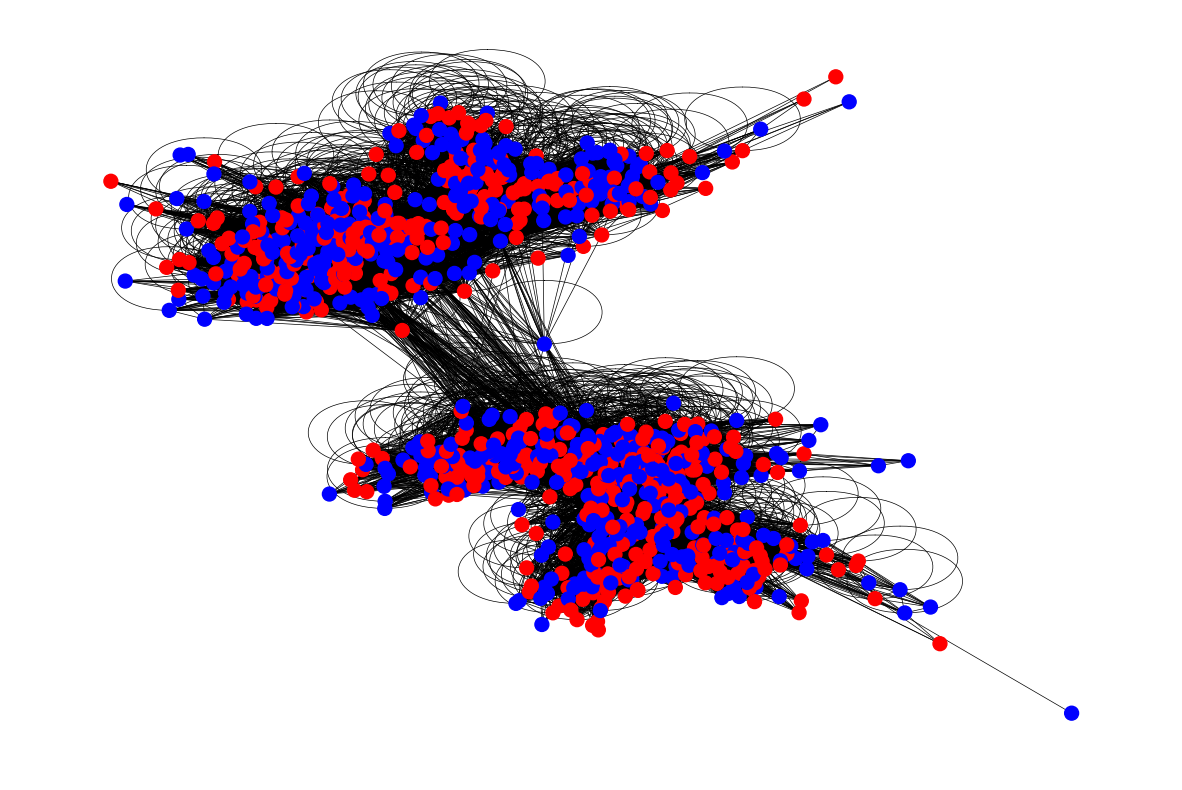

KeyboardInterrupt: 

In [12]:
c = 83
T = 10
zstar,Lstar,LL,pc = fit_DCSBM(G1,c,T)
print(f'phase[{pc}] z0, logL = {Lstar}')
drawGz(G1,zstar)
plotLL(LL,pc,G1.order())
wrs,kpr = tabulate_wk(G1,zstar,c)
print(f'kappa_r = ')
print(kpr)
print(f'w_rs = ')
print(wrs)